In [1]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer

In [2]:
import data_loader
from data_loader import load_data_dicts_for

In [3]:
import numpy as np
import os

In [5]:
country = 'Czech'
train_dicts = load_data_dicts_for(country, 'train_split')

In [6]:
def get_train_data():
    return train_dicts

In [7]:
# Register train dataset
DatasetCatalog.register("road_damage_train", get_train_data)
MetadataCatalog.get("road_damage_train").set(thing_classes=['D00', 'D10', 'D20', 'D40'])

namespace(name='road_damage_train', thing_classes=['D00', 'D10', 'D20', 'D40'])

In [8]:
road_damage_metadata = MetadataCatalog.get("road_damage_train")

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
OUTPUT_DIR = f'./output_r101_base_{country}'
cfg = get_cfg()
cfg.OUTPUT_DIR = OUTPUT_DIR
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("road_damage_train",)
cfg.DATASETS.TEST = ()
# # for validation
# cfg.DATASETS.TEST = ("road_damage_val",)
# cfg.TEST.EVAL_PERIOD = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 5000

cfg.DATALOADER.NUM_WORKERS = 0
# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-101.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8

# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000

cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.MOMENTUM = 0.9

cfg.SOLVER.NESTEROV = False

cfg.SOLVER.WEIGHT_DECAY = 0.0001
# The weight decay that's applied to parameters of normalization layers
# (typically the affine transformation)
cfg.SOLVER.WEIGHT_DECAY_NORM = 0.0

cfg.SOLVER.GAMMA = 0.1
# The iteration number to decrease learning rate by GAMMA.
cfg.SOLVER.STEPS = (20000,)

cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"

# Save a checkpoint after every this number of iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 5000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 #12500 # 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# cfg.MODEL.DEVICE = 'cuda:0'


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [11]:
!pip install albumentations

     |████████████████████████████████| 117 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 948 kB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 7.2 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65162 sha256=cf144a685ec2f386bcfca34e88e19516e065df3e6831fdb11ac19e5b752f126a
  Stored in directory: /home/idvl1/.cache/pip/wheels/d2/e3/0b/99a239413035502833a7b07283894243fddf5ce3aa720ca8dd
Successfully built albumentations


In [31]:
import trainer_with_augmentation
import importlib
importlib.reload(trainer_with_augmentation)
from trainer_with_augmentation import build_augmentation, train_transforms, MyDatasetMapper, get_all_locs
from vis_utils import cv2_imshow
from detectron2.data import build_detection_train_loader

In [32]:
# # try sample damage of a type
# s = sample_a_damage_of_type(train_dicts, 2)
# damage = s['damage']
# damage_masked=s['damage_masked']
# cv2_imshow(damage)
# cv2_imshow(damage_masked)

In [36]:
augs = build_augmentation(cfg)
all_locs = get_all_locs(train_dicts)
mapper = MyDatasetMapper(augs, all_locs, train_dicts, for_vis=True, sample_probs=[0.5, 0.5, 0.5, 0.5])
my_data_loader = build_detection_train_loader(cfg, mapper=mapper)

In [37]:
data_loader_iter = iter(my_data_loader)

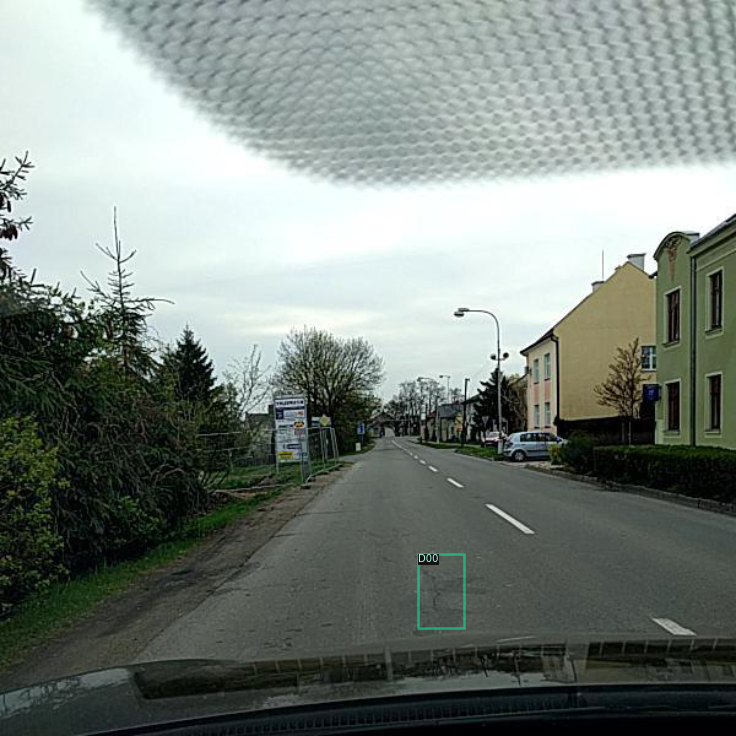

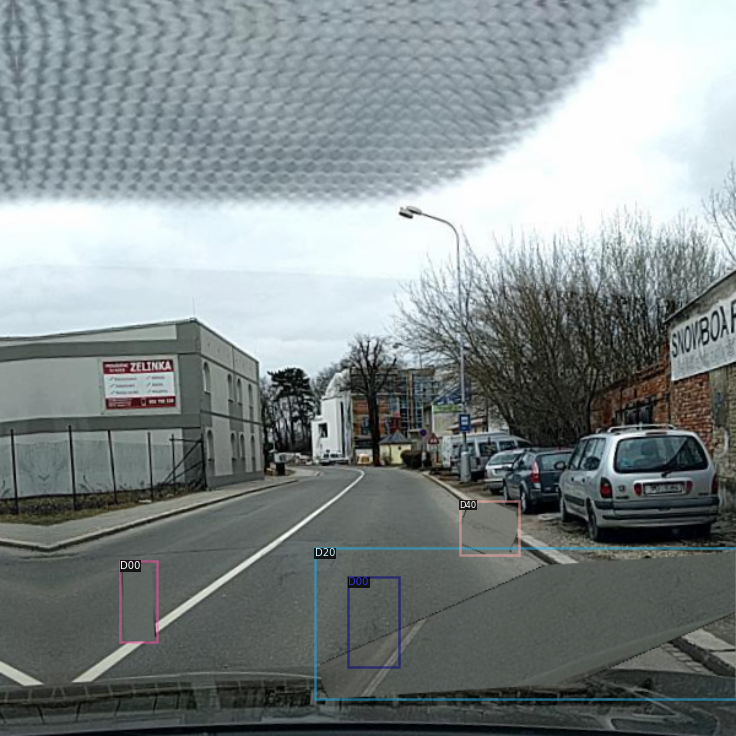

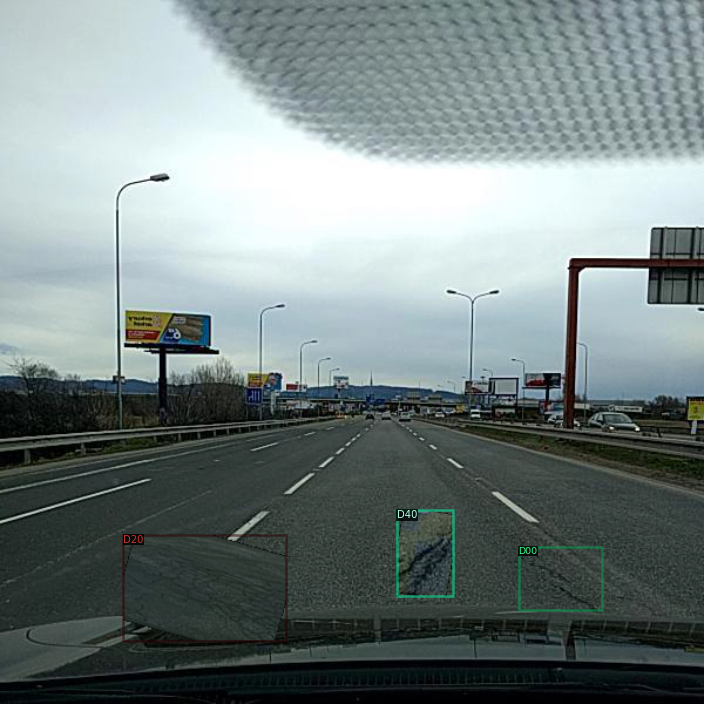

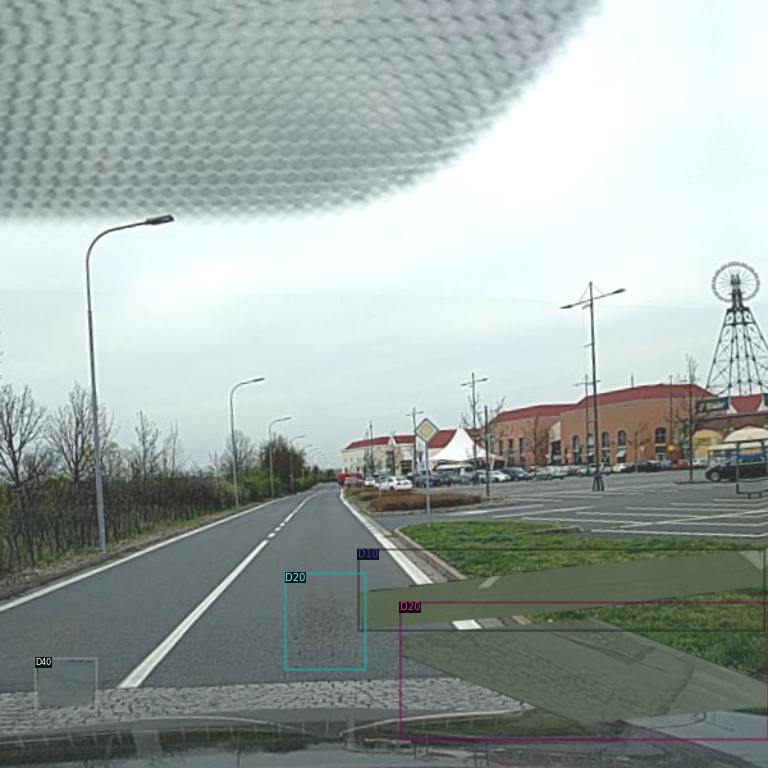

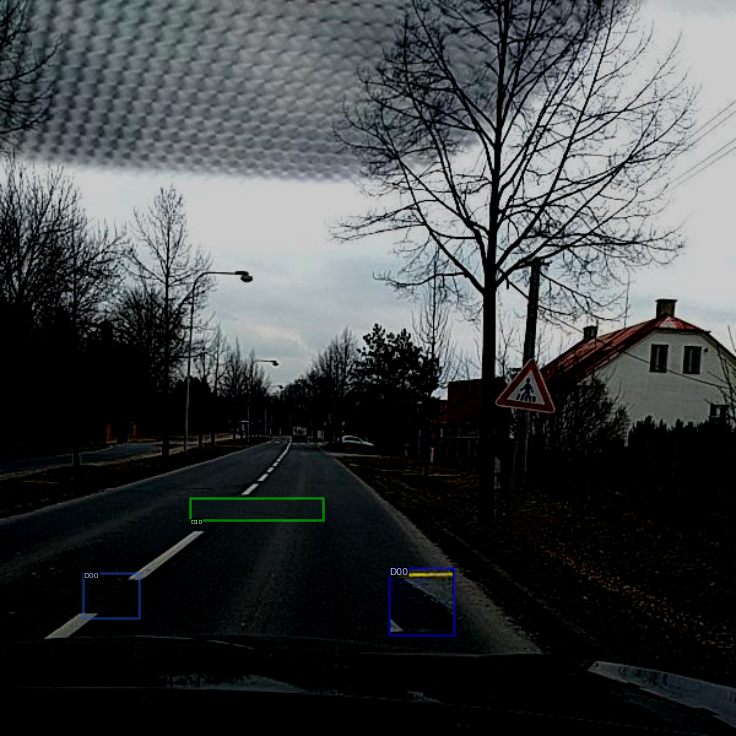

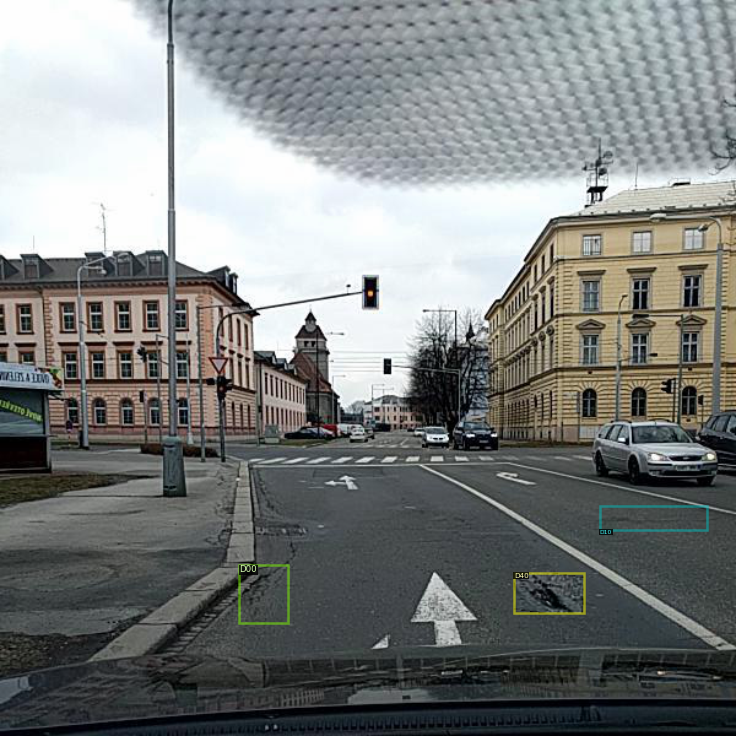

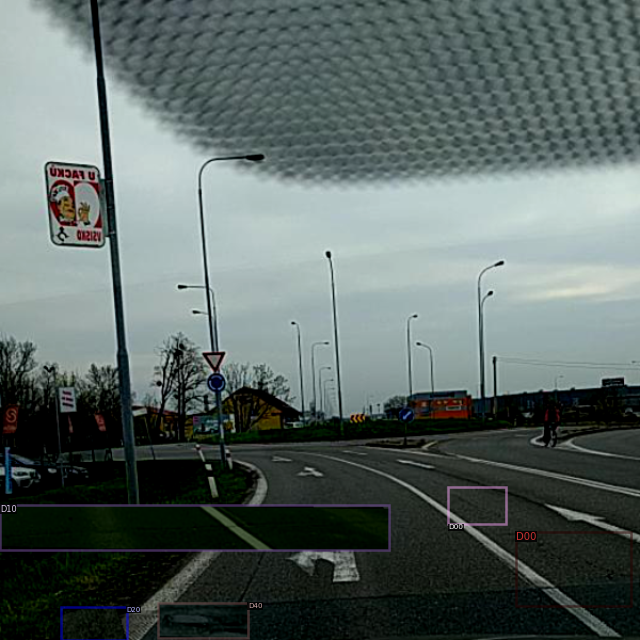

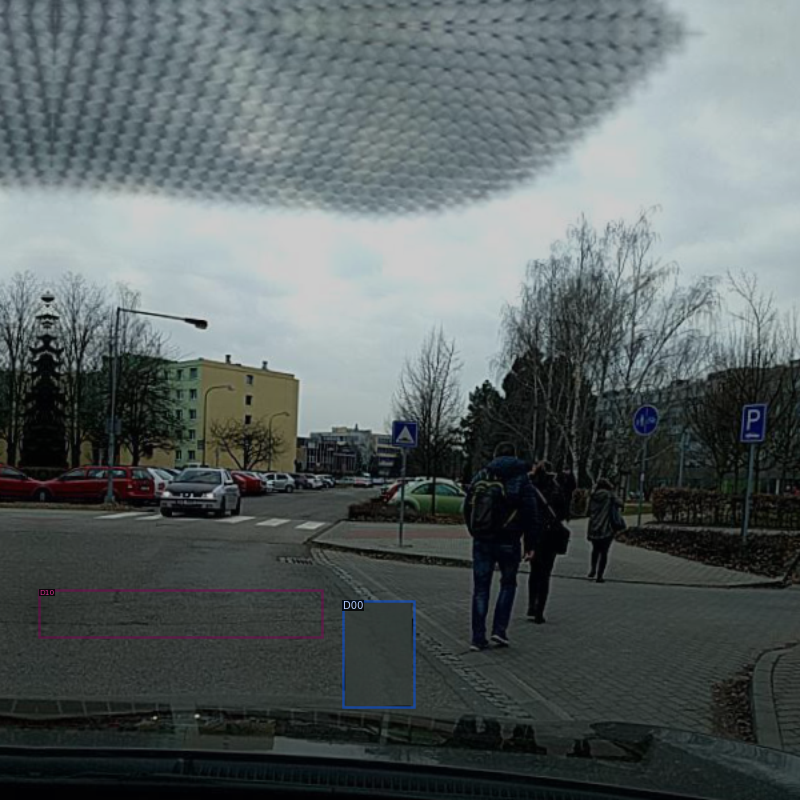

In [38]:
batch = next(data_loader_iter)
for d in batch:
    img = d['image'].to("cpu").permute(1, 2, 0).numpy()
    v = Visualizer(img, metadata=road_damage_metadata, scale=1.0)
    v = v.draw_dataset_dict(d)
    cv2_imshow(v.get_image())